In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from scipy.signal import find_peaks, convolve, medfilt, savgol_filter
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import matplotlib.animation as animation
import matplotlib as mpl
from glob import glob
from copy import copy
from natsort import natsorted
from pandas import DataFrame
import pickle
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
sys.path.insert(0, parent_dir)
import matplotlibcolors
plt.style.use(parent_dir + '/matplotlibrc')


%matplotlib widget

In [2]:
def load_files(files):
    s21s = []
    for i, file in enumerate(files):
        freqs, s21 = np.load(file)
        s21s.append(s21)
    return freqs, np.array(s21s)

def load_dat_file(file):
    data = np.loadtxt(file, skiprows=0)
    freqs = data[:, 0]
    s21 = data[:, 1]
    return freqs, s21

def track_tones(s21, locs, limit=5):
    for i, loc in enumerate(locs):
        init_loc = copy(loc)
        prev = s21[loc-1]
        now = s21[loc]
        next = s21[loc+1]
        if next < now:
            while next < now:
                loc += 1
                prev = now
                now = next
                next = s21[loc+1]
        elif next > now:
            while prev < now:
                loc -= 1
                next = now
                now = prev
                prev = s21[loc-1]
        elif next >= now and prev <= now:
            print('At min: ', i)
        else:
            print('No min: ', i)
        if abs(loc - init_loc) <= limit:
            locs[i] = loc
        else:
            print('Too far: ', i)   
    _, unique_indices = np.unique(locs, return_index=True)
    unique_mask = np.zeros(locs.shape, dtype=bool)
    unique_mask[unique_indices] = True
    return locs, unique_mask

def smooth_sweep(s21):
    window_length = 5
    polyorder = 3
    smooth_s21 = savgol_filter(s21, window_length, polyorder)
    return smooth_s21

def readout_tones(tones, s21s, dark):
    s21_mins = dark[tones]
    nr_kids = len(tones)
    nr_scans = s21s.shape[0]
    ds21s = np.empty((nr_scans, nr_kids))
    for i, s21 in enumerate(s21s):
        smooth_s21 = smooth_sweep(s21)
        ds21s[i, :]  = smooth_s21[tones] - s21_mins
    return ds21s

def get_pos(ds21s, mpp):
    nr_kids = ds21s.shape[1]
    pos = np.empty((nr_kids)) # f0, 
    pos[:] = np.nan
    maxproms = np.empty((nr_kids)) # f0, 
    maxproms[:] = np.nan
    secproms = np.empty((nr_kids)) # f0, 
    secproms[:] = np.nan
    doubles = []
    for i in range(nr_kids):
        ds21 = ds21s[:, i]
        y = medfilt(ds21, 3)
        x = np.arange(len(y))
        a, b = np.polyfit(x, y, 1)
        ds21 -= (a*x + b)
        ds21s[:, i] = ds21
        baseline = y - (a*x + b)
        argsort = np.argsort(ds21)
        argmax = argsort[-1]
        secargmax = argsort[-2]
        max = ds21[argmax]
        secmax = ds21[secargmax]
        mean = np.mean(baseline)
        maxprom = max - mean
        secprom =  secmax - mean
        pos[i] = argmax
        maxproms[i] = maxprom
        secproms[i] = secprom
        if secprom >= mpp: 
            if len(doubles):
                if doubles[-1] != i-1:
                    doubles.append(i)
                else:
                    doubles = doubles[:-1]
            else:
                doubles.append(i)
    print('Mean prominence: ', np.mean(maxproms))
    fig, ax = plt.subplot_mosaic('ab', figsize=(4,2))
    hist = ax['a'].hist(pos, bins=np.arange(ds21s.shape[0]+1), facecolor='tab:blue', edgecolor='w')
    ax['b'].axvline(mpp, c='r')
    # ax['a'].axhline(nr_rows, c='r')
    ax['b'].hist(maxproms, bins='auto')
    ax['b'].hist(secproms, bins='auto')
    print('total: ', np.sum(~np.isnan(pos)))
    print('nr doubles: ', len(doubles))
    print(doubles)
    return pos, maxproms, secproms, doubles

def add_kids(added, to_add):
    global rows, cols, maxproms, secproms, f0s, ds21s_rows, ds21s_cols, locs  # Declare global variables

    added = np.array(added, dtype=int)
    to_add = np.array(to_add, dtype=int)
    secargmax_rows = np.argsort(ds21s_rows[:, to_add], axis=0)[-2, :]
    rows = np.insert(rows, to_add, secargmax_rows)
    ds21s_rows = np.insert(ds21s_rows, to_add, ds21s_rows[:, to_add], axis=1)
    secargmax_cols = np.argsort(ds21s_cols[:, to_add], axis=0)[-2, :]
    cols = np.insert(cols, to_add, secargmax_cols)
    ds21s_cols = np.insert(ds21s_cols, to_add, ds21s_cols[:, to_add], axis=1)
    maxproms = np.insert(maxproms, to_add, secproms[to_add])
    secproms = np.insert(secproms, to_add, maxproms[to_add])
    f0s = np.insert(f0s, to_add, f0s[to_add])
    locs = np.insert(locs, to_add, locs[to_add])
    to_add = np.sort(to_add)
    to_add += np.arange(len(to_add))
    for kid in to_add:
        added[added >= kid] += 1
        added = np.hstack((added, kid, kid+1))
    return list(np.sort(added))

def del_kids(added, to_delete):
    global rows, cols, maxproms, secproms, f0s, ds21s_rows, ds21s_cols, locs  # Declare global variables

    to_delete = np.sort(to_delete)
    to_delete = np.array(to_delete, dtype=int)
    added = np.array(added, dtype=int)
    
    rows = np.delete(rows, to_delete)
    cols = np.delete(cols, to_delete)
    maxproms = np.delete(maxproms, to_delete)
    secproms = np.delete(secproms, to_delete)
    f0s = np.delete(f0s, to_delete)
    ds21s_rows = np.delete(ds21s_rows, to_delete, axis=1)
    ds21s_cols = np.delete(ds21s_cols, to_delete, axis=1)
    locs = np.delete(locs, to_delete)
    for kid in to_delete[::-1]:
        if kid in added:
            added = np.delete(added, np.argwhere(added == kid))
        if kid-1 in added: 
            added = np.delete(added, np.argwhere(added == kid-1))
        elif kid+1 in added: 
            added = np.delete(added, np.argwhere(added == kid+1))
        added[added >= kid] -= 1
    return list(added)

def plot_dipshit(s21s, ds21s, pos, kids, steps=[], bw=50):
    global f0s, locs, freqs, smooth_avg_s21
    fig, ax = plt.subplot_mosaic('ba', figsize=(10,5), constrained_layout=True)
    custom_colors = ['b', 'y', 'g', 'p']

    for kid in kids:
        ds21 = ds21s[:, kid]
        baseline = medfilt(ds21, 3)
        res = f0s[kid]
        loc = locs[kid]
        index = np.arange(loc-bw,loc+bw)
        hit = int(pos[kid])
        ax['b'].axhline(np.mean(baseline), ls='--', lw=1, c='k')
        ax['a'].plot(freqs[index], smooth_avg_s21[index], lw=2, label='dark', c='k')
        ax['a'].axvline(res, c='k', ls='--', lw=1)
        ax['a'].plot(freqs[index], smooth_sweep(s21s[hit, index]), lw=2, label='hit @' + str(hit), c='r')
        ax['b'].axvline(hit, ls='--', lw=2, c='r')
        for i, step in enumerate(steps):
            ax['a'].plot(freqs[index], smooth_sweep(s21s[step, index]), lw=1, label=str(step), c=custom_colors[i])
            ax['b'].axvline(step, ls='--', lw=1, c=custom_colors[i])
        ax['b'].plot(ds21, lw=2, label=str(kid), c='k')
    ax['b'].legend()
    ax['a'].legend()

def plot_rows(rows, doubles=[], lo=None):    
    global f0s, nr_cols
    fig, ax = plt.subplot_mosaic('aaaab', figsize=(14,9), constrained_layout=True, sharey=True)   
    custom_colors = ['r', 'o', 'y', 'g', 'b', 'p']
    custom_cmap = mpl.colors.ListedColormap(custom_colors)
    ax['a'].scatter(f0s, rows, c=maxproms, cmap=custom_cmap)
    cbar = fig.colorbar(ax['a'].collections[0], ax=ax['a'], orientation='vertical', location='left')
    cbar.set_label('Max Prominence')
    for id, row in enumerate(rows):
        ax['a'].annotate(id, (f0s[id], row+.3), fontsize=8, ha='center', va='center', rotation=-45)
    for id in doubles:
        ax['a'].scatter(f0s[id], rows[id], marker='o', facecolor='None', edgecolor='k', linewidth=2)
    min_pos = np.nanmin(rows)
    max_pos = np.nanmax(rows)
    binedges = np.arange(min_pos, max_pos+2, 1)
    ax['a'].set_yticks(binedges)
    hist = ax['a'].grid(True, which='both', linestyle='--', lw=.5)
    if lo:
        ax['a'].axvline(lo, c='k', ls='-', lw=1)
        lo_mask = f0s < lo
        ax['b'].hist([rows[lo_mask], rows[~lo_mask]], bins=binedges-.5, edgecolor='w', orientation='horizontal', label=['< LO', '> LO'], stacked=True)
        ax['b'].axvline(nr_cols/2, c='k', ls='-', lw=1)
    else:
        ax['b'].hist(rows, bins=binedges-.5, edgecolor='w', orientation='horizontal')
    ax['b'].axvline(nr_cols, c='k', ls='-', lw=2)
    ax['b'].legend()

def plot_cols(rows, doubles=[], lo=None):    
    global f0s, nr_rows
    fig, ax = plt.subplot_mosaic('b;a;a;a;a', figsize=(9,14), constrained_layout=True, sharex=True)   
    custom_colors = ['r', 'o', 'y', 'g', 'b', 'p']
    custom_cmap = mpl.colors.ListedColormap(custom_colors)
    ax['a'].scatter(rows, f0s, c=maxproms, cmap=custom_cmap)
    cbar = fig.colorbar(ax['a'].collections[0], ax=ax['a'], orientation='horizontal', location='bottom')
    cbar.set_label('Max Prominence')
    for id, col in enumerate(rows):
        ax['a'].annotate(id, (col+.3, f0s[id]), fontsize=8, ha='center', va='center', rotation=-45)
    for id in doubles:
        ax['a'].scatter(rows[id], f0s[id], marker='o', facecolor='None', edgecolor='k', linewidth=2)
        ax['a'].scatter(rows[id+1], f0s[id+1], marker='o', facecolor='None', edgecolor='k', linewidth=2)
    min_pos = np.nanmin(rows)
    max_pos = np.nanmax(rows)
    binedges = np.arange(min_pos, max_pos+2, 1)
    ax['a'].set_xticks(binedges)
    hist = ax['a'].grid(True, which='both', linestyle='--', lw=.5)
    if lo:
        ax['a'].axhline(lo, c='k', ls='-', lw=1)
        lo_mask = f0s < lo
        ax['b'].hist([rows[lo_mask], rows[~lo_mask]], bins=binedges-.5, edgecolor='w', label=['< LO', '> LO'], stacked=True)
        ax['b'].axhline(nr_rows/2, c='k', ls='-', lw=1)
    else:
        ax['b'].hist(rows, bins=binedges-.5, edgecolor='w')
    ax['b'].axhline(nr_rows, c='k', ls='-', lw=2)
    ax['b'].legend()

def map_kids(nans, roll):
    global rows, nr_rows, nr_cols
    row_list = [[] for _ in range(nr_rows)]
    for id, row in enumerate(rows):
        if not np.isnan(row):
            row_list[int(row)].append(int(id))
    map_sorted = np.empty((nr_rows, nr_cols))
    map_sorted[:] = np.nan   
    for i, row in enumerate(row_list):
        map_sorted[i, :len(row)] = row
    for i, j in nans:
        map_sorted[i, j+1:] = map_sorted[i, j:-1]
        map_sorted[i, j] = np.nan
    map = copy(map_sorted)
    for i, row in enumerate(map_sorted):
        map[i] = np.roll(row, i*roll)
    fig, ax = plt.subplot_mosaic('ab', figsize=(5,3), constrained_layout=True)
    ax['a'].imshow(map_sorted, cmap='viridis', origin='lower')
    ax['b'].imshow(map, cmap='viridis', origin='lower')
    return map

def common_mode(x, y, deg):
    coeff = np.polyfit(x, y, deg)
    cmode = np.poly1d(coeff)
    print(cmode)
    return cmode

def comp_scatter(design, meas, deg): 
    nanmask = np.isnan(meas) + np.isnan(design) 
    cmode = common_mode(design[~nanmask], meas[~nanmask], deg)
    design_fit = cmode(design)
    scatter = (meas - design_fit) / design_fit
    return scatter, cmode

def plot_scatter(deg=1, annotate=False, clim=[]):
    global design, meas, nanmask, kid_id_board, nr_rows, nr_cols, kids

    df_f, cmode = comp_scatter(design, meas, deg)
    df_f_map = df_f[kid_id_board]
    flim = np.array([np.nanmin((design, meas)), np.nanmax((design, meas))])
    xfit = np.linspace(flim[0], flim[1])
    yfit = cmode(xfit)

    fig, ax = plt.subplot_mosaic('abc', figsize=(16, 5), constrained_layout=True)
    ax['a'].scatter(design, design, c='None', edgecolor='tab:blue', label='$\it f_0^{design}$')
    ax['a'].scatter(design, meas, c='None', edgecolor='tab:orange', label='$\it f_0^{meas}$')
    ax['a'].plot(xfit, yfit, c='k', label='common mode, deg=%d' % (len(cmode.c)-1), ls='--', lw=0.5)
    ax['a'].set_xlabel('$\it f_0^{design}$ $[GHz]$')
    ax['a'].set_ylabel('$\it f_0$ $[GHz]$')
    ax['a'].set_xlim(flim)
    ax['a'].set_ylim(flim)
    ax['a'].legend(loc='upper left')
    if not len(clim):
        clim = [np.amin(df_f[~nanmask]), np.amax(df_f[~nanmask])]
    ax['b'].scatter(design, df_f, c=df_f, vmin=clim[0], vmax=clim[1], label='residual')
    ax['b'].annotate
    ax['b'].set_ylabel('$\it df*/f$')
    ax['b'].set_xlabel('$\it f_0^{design}$ $[GHz]$')
    im = ax['c'].imshow(df_f_map, cmap='viridis', origin='lower', vmin=clim[0], vmax=clim[1])
    if annotate:
        for i, x in enumerate(df_f_map):
            for j, y in enumerate(x):
                if ~np.isnan(y):
                    old_id = kid_id_board[i, j]
                    new_id = kids[i, j]
                    if old_id == new_id:
                        c = 'w'
                    else:
                        c = 'r'
                    ax['c'].text(j, i, '%d' % new_id, ha='center', va='center', fontsize=6, color='w', rotation=45)
    # Major ticks
    ax['c'].set_xticks(np.arange(0, nr_cols, 1)-0.5, minor=False)
    ax['c'].set_yticks(np.arange(0, nr_rows, 1)-0.5, minor=False)
    ax['c'].set_xticks(np.arange(0, nr_cols, 1), minor=True)
    ax['c'].set_yticks(np.arange(0, nr_rows, 1), minor=True)
    # Labels for major ticks
    ax['c'].set_xticklabels(np.arange(0, nr_cols, 1), minor=True, rotation=-90)
    ax['c'].set_yticklabels(np.arange(0, nr_rows, 1), minor=True, rotation=0)
    ax['c'].set_yticklabels([], minor=False)
    ax['c'].set_xticklabels([], minor=False)
    ax['c'].grid(which='major', linestyle='-', linewidth=0.5)
    ax['c'].grid(which='minor', visible=False)
    ax['c'].set_xlabel('$\it x$ $[px]$')
    ax['c'].set_ylabel('$\it y$ $[px]$')
    cbar = fig.colorbar(im, ax=ax['c'])
    _ = cbar.ax.set_ylabel('$\it df*/f$')

    scatter = np.std(df_f[~nanmask])
    pxl_yield = (np.sum(~np.isnan(meas))/(nr_rows*nr_cols))
    print('scatter = %.3f%%' % (scatter*1e2))
    print('yield = %.3f%%' % (pxl_yield*1e2))
    return df_f, df_f_map

def image(ds21s):
    global nr_rows, nr_cols

    nr_scans = ds21s.shape[0]
    maps = np.zeros((nr_rows, nr_cols, nr_scans))
    for nr in range(nr_scans):
        for i, m in enumerate(kids):
            for j, k in enumerate(m):
                if ~np.isnan(k):
                    k = int(k)
                    ds21s[:, k] -= np.amin(ds21s[:, k])
                    ds21s[:, k] /= np.amax(ds21s[:, k])
                    maps[i, j, nr] = ds21s[nr, int(k)]
                else:
                    maps[i, j, nr] = np.nan
    return maps

def plot_image(map, annotate=True):
    global kids
    
    fig, ax = plt.subplots(figsize=(8,8))
    cax = ax.imshow(map, origin='lower', cmap='viridis')
    M, N = map.shape
    for i, x in enumerate(kids):
        for j, y in enumerate(x):
                if ~np.isnan(y):
                    new_id = kids[i, j]
                    ax.text(j, i, '%d' % new_id, ha='center', va='center', fontsize=7, color='r')
    # Major ticks
    ax.set_xticks(np.arange(0, N, 1)-0.5, minor=False)
    ax.set_yticks(np.arange(0, N, 1)-0.5, minor=False)
    ax.set_xticks(np.arange(0, M, 1), minor=True)
    ax.set_yticks(np.arange(0, M, 1), minor=True)
    # Labels for major ticks
    ax.set_xticklabels(np.arange(0, N, 1), minor=True, rotation=0)
    ax.set_yticklabels(np.arange(0, M, 1), minor=True, rotation=0)
    ax.set_yticklabels([], minor=False)
    ax.set_xticklabels([], minor=False)
    ax.grid(which='major', linestyle='-', linewidth=0.5)
    ax.grid(which='minor', visible=False)
    return fig, cax

def animate_image(maps, annotate=False, save=None):
    fig, cax = plot_image(maps[:,:, 0], annotate=annotate)
    nr_scans = maps.shape[2]
    def update(frame):
        cax.set_array(maps[:, :, frame])
        return cax,
    ani = animation.FuncAnimation(fig, update, frames=nr_scans, interval=200, blit=True)
    if save:
        ani.save(save, writer='Pillow')
    return ani

def rel_freqs(f0, f1, nr_kids):
    oct = np.log2(f1/f0)
    spacing = 2**(oct/(nr_kids-1))
    powers = np.arange(nr_kids)
    f0s = f0 * (spacing)**powers
    return f0s

In [3]:
dir  = r"C:\Users\wilbertr\ownCloud2\PhD\PhD\PythonProjects\sonnet\LT402 Design/"
chip = 'LT402_32x32_4-8GHz'
path = dir + chip + '/'
with open(path + 'LT402chip6_master.pkl', 'rb') as f:
    master = pickle.load(f)

kid_id_board = np.load( path + chip + '_id.npy')

dir = '.\S21s_20250930_13h38/'
yfiles = natsorted(glob(dir + '*y*.npy'))[::-1]
xfiles = natsorted(glob(dir + '*x*.npy'))
freqs, s21s_rows = load_files(yfiles)
s21s_cols = load_files(yfiles)[1]
avg_s21 = np.mean(s21s_rows, axis=0)

nr_rows = 32
nr_cols = 32
nr = nr_rows * nr_cols

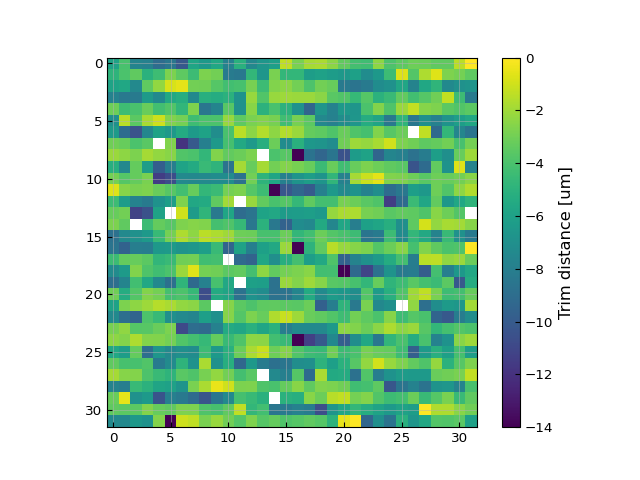

In [4]:
fig, ax = plt.subplots()
trims = master['trimdesign masker']['fingers'] - master['design']['fingers']
ax.imshow(trims[kid_id_board], vmin=-14)
cbar = fig.colorbar(ax.images[0], ax=ax)
cbar.set_label('Trim distance [um]')

Too far:  195
Too far:  287
Too far:  343
Too far:  618
Too far:  941
Too far:  989
Total:  1015
Too close, within 0.1 MHz:  1 , ids:  [941]
Overlapping:  5 , ids:  [ 10  73 168 197 904]


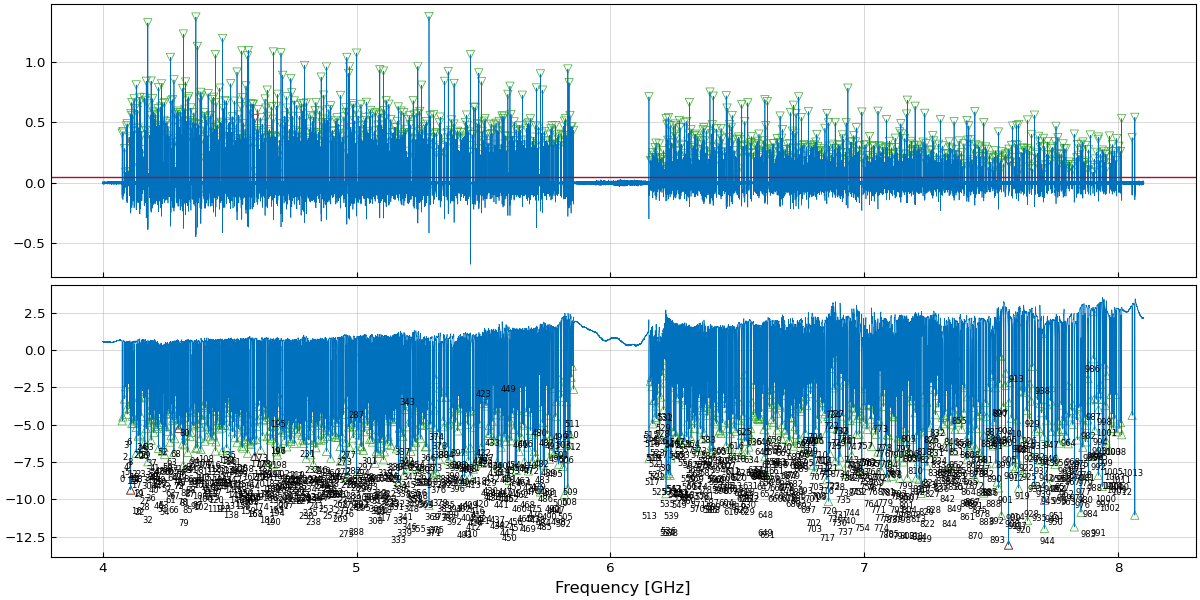

In [5]:
mph = .05
min_df = .1
smooth_avg_s21 = smooth_sweep(avg_s21)
d2s21 = np.diff(smooth_avg_s21, 2)

init_locs, props = find_peaks(d2s21, height=mph, prominence=mph)
heights = props['peak_heights']

init_locs, unique_mask = track_tones(smooth_avg_s21, init_locs)
# unique_mask[414] = 0

init_f0s = freqs[init_locs]
s21_mins = smooth_avg_s21[init_locs]

# BEGIN:
too_close_mask = np.zeros(init_f0s.shape, dtype=bool)
for i in range(len(init_f0s) - 1):
    if np.abs(init_f0s[i] - init_f0s[i + 1]) < min_df*1e-3 and (unique_mask[i] and unique_mask[i + 1]):
        if s21_mins[i] < s21_mins[i + 1]:
            too_close_mask[i + 1] = True
        else:
            too_close_mask[i] = True

fig, ax = plt.subplot_mosaic('a;b', sharex=True, figsize=(12, 6), constrained_layout=True)
ax['a'].plot(freqs[2:], d2s21, lw=.5)
ax['b'].plot(freqs, smooth_avg_s21, lw=.5)
# ax['b'].plot(freqs, s21s[0], lw=.5, ls='--')
ax['a'].axhline(mph, c='r')
mask = ~too_close_mask & unique_mask
ax['a'].scatter(freqs[init_locs[mask]], heights[mask], marker='v', c='None', edgecolor='g')
ax['b'].scatter(init_f0s[mask], s21_mins[mask], marker='^', c='None', edgecolor='g')
ax['a'].scatter(freqs[init_locs[too_close_mask]], heights[too_close_mask], marker='v', c='None', edgecolor='p')
ax['b'].scatter(init_f0s[too_close_mask], s21_mins[too_close_mask], marker='^', c='None', edgecolor='p')
ax['a'].scatter(freqs[init_locs[~unique_mask]], heights[~unique_mask], marker='v', c='None', edgecolor='r')
ax['b'].scatter(init_f0s[~unique_mask], s21_mins[~unique_mask], marker='^', c='None', edgecolor='r')
for i, loc in enumerate(init_locs):
    ax['b'].annotate(f'{i}', (init_f0s[i], s21_mins[i]-5), textcoords="offset points", xytext=(0,10), ha='center', fontsize=6)
ax['b'].set_xlabel('Frequency [GHz]')
print('Total: ', len(init_locs))
print('Too close, within', min_df, 'MHz: ', len(init_locs[too_close_mask]), ', ids: ', np.arange(len(init_locs))[too_close_mask])
print('Overlapping: ', len(init_locs[~unique_mask]), ', ids: ', np.arange(len(init_locs))[~unique_mask])

Mean prominence:  3.6536239303958546
total:  1010
nr doubles:  15
[9, 91, 165, 559, 615, 629, 876, 899, 902, 918, 925, 946, 958, 964, 984]
Mean prominence:  3.6536239303958546
total:  1010
nr doubles:  15
[9, 91, 165, 559, 615, 629, 876, 899, 902, 918, 925, 946, 958, 964, 984]
[9, 10, 166, 167, 896, 897, 915, 916, 923, 924, 962, 963]


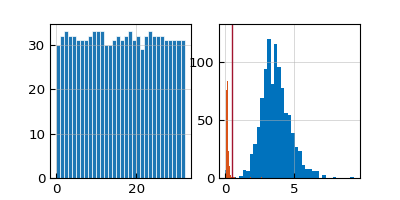

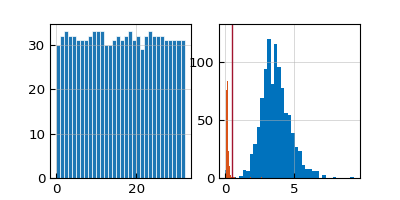

In [6]:
mask = unique_mask
locs = init_locs[mask]
f0s = init_f0s[mask]

ds21s_rows = readout_tones(locs, s21s_rows, avg_s21)
ds21s_cols = readout_tones(locs, s21s_cols, avg_s21)

mpp = 0.5
rows, maxproms, secproms, doubles = get_pos(ds21s_rows, mpp)
cols, _, _, xdoubles = get_pos(ds21s_cols, mpp)


doubles = add_kids([], doubles)
delete = [882, 342, 562, 917, 92, 944, 998, 422, 970, 910, 619, 448, 286, 998, 634]
doubles = del_kids(doubles, delete)
delete = [945]
doubles = del_kids(doubles, delete)
delete = [194]
doubles = del_kids(doubles, delete)
delete = [980]
doubles = del_kids(doubles, delete)
print(doubles)

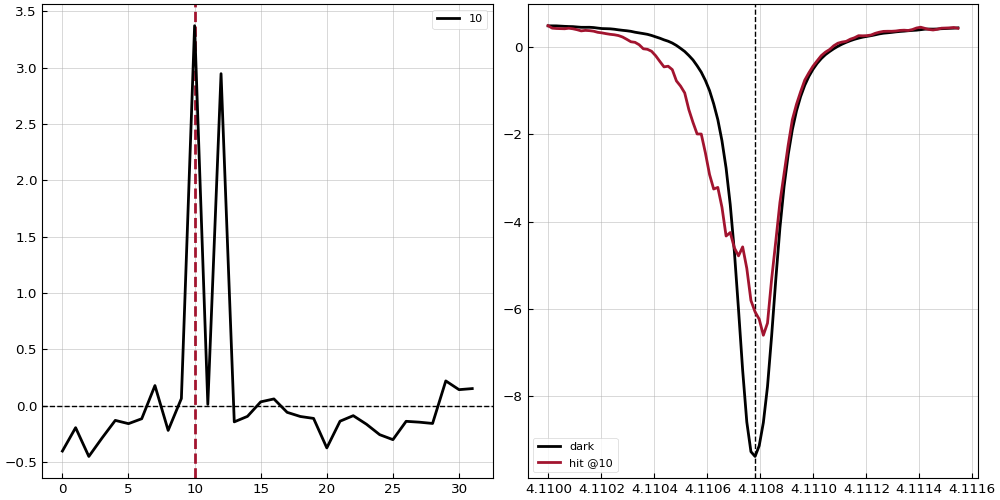

In [7]:
kids = [10]
steps = []
plot_dipshit(s21s_rows, ds21s_rows, rows, kids, steps)
# plot_dipshit(s21s_cols, ds21s_cols, cols, [kid], [10])

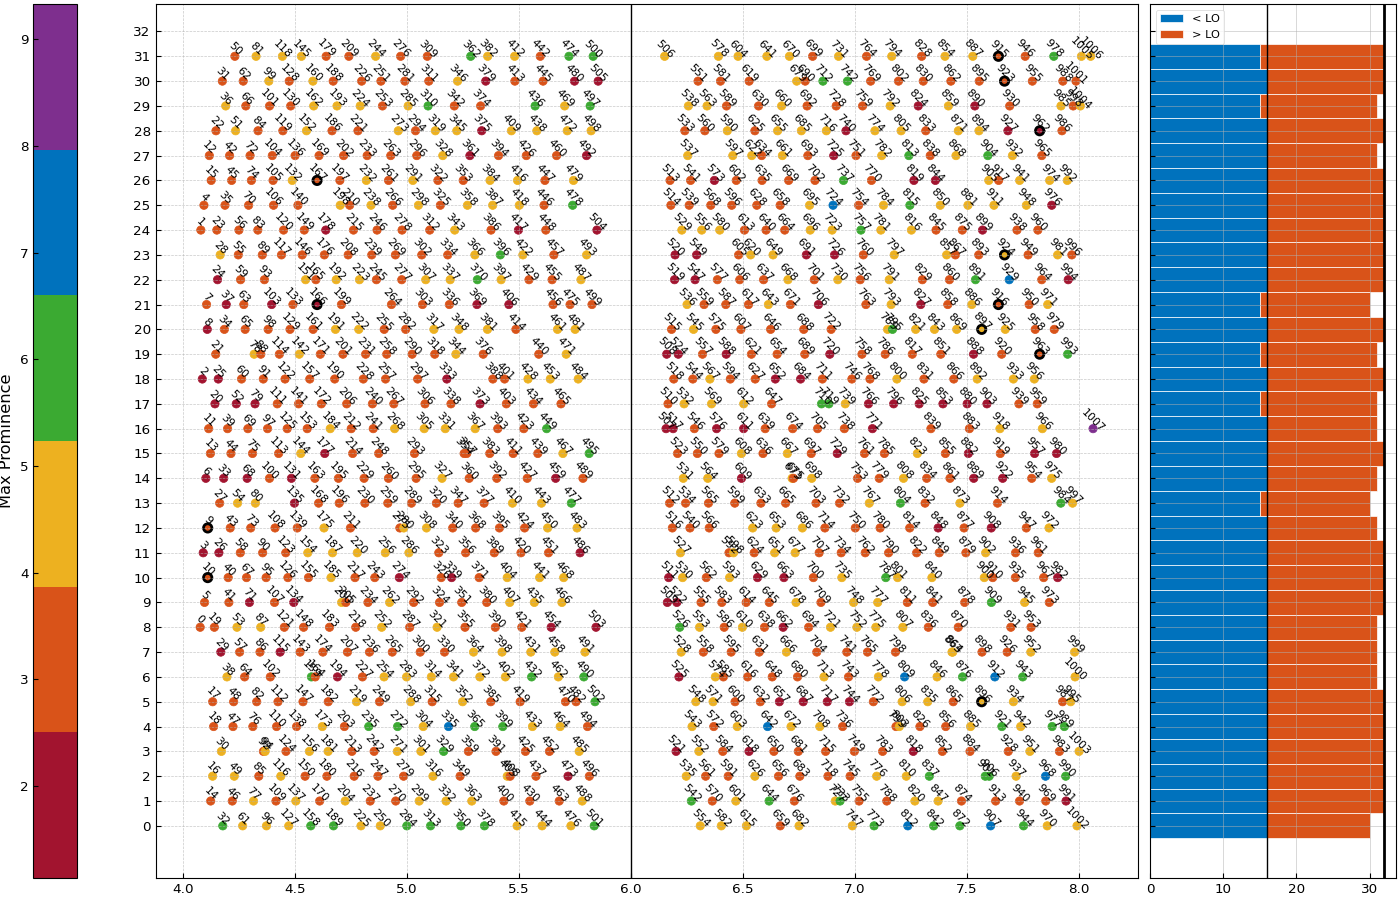

In [8]:
plot_rows(rows, doubles, lo=6)

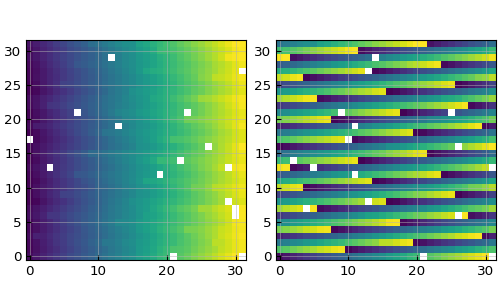

In [7]:
nans = [[0, 21], [0, 31],
        [6, 30], 
        [7, 30],
        [8, 29], 
        [12, 19], 
        [13, 3], [13, 29], 
        [14, 22],
        [16, 26],
        [17, 0],
        [19, 13],
        [21, 7], [21, 23],
        [27, 31], 
        [29, 12]]

kids = map_kids(nans, 10)

In [8]:
swaps = [[20, [0, -1]], [4,[0, -1]],[3,[0, -1]],[1,[0, -1]],[5,[16, 17]],[11,[0, -1]]]
for row, [a,b] in swaps:
    kids[row, a], kids[row, b] = kids[row, b], kids[row, a]

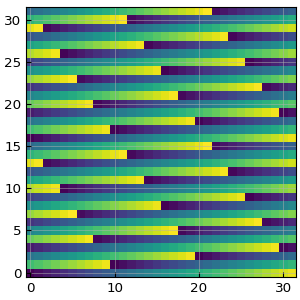

In [9]:
finger_lengths = master['trimdesign masker']['fingers']
design_f0s = master['trimdesign masker']['f0']
# coupler_lengths = master['trimdesign']['couplers']
fig, ax = plt.subplot_mosaic('a', figsize=(3,3), constrained_layout=True, sharey=True)   
ax['a'].imshow(kid_id_board, cmap='viridis', origin='lower')

In [10]:
master['trimmeasured'] = {}
master['trimmeasured']['f0'] = np.empty(nr_rows*nr_cols)
master['trimmeasured']['f0'][:] = np.nan
for i, row in enumerate(kid_id_board):
    for j, idx in enumerate(row):
        meas_idx = kids[i, j]
        if ~np.isnan(meas_idx):
            meas_f = f0s[int(meas_idx)]
            master['trimmeasured']['f0'][idx] = meas_f

outliers_f0 = master['trimmeasured outliers']['f0']
for i in range(len(outliers_f0)):
    outlier_f0 = outliers_f0[i]
    if ~np.isnan(outlier_f0):
        master['trimmeasured']['f0'][i] = outlier_f0

design = master['trimdesign masker']['f0']
meas = master['trimmeasured']['f0']
nanmask = np.isnan(meas) + np.isnan(design)
sort_idx = np.argsort(meas[~nanmask])
inverse_sort_idx = np.argsort(sort_idx)



           2
-0.001188 x + 1.013 x - 0.03849
scatter = 0.029%
yield = 99.609%


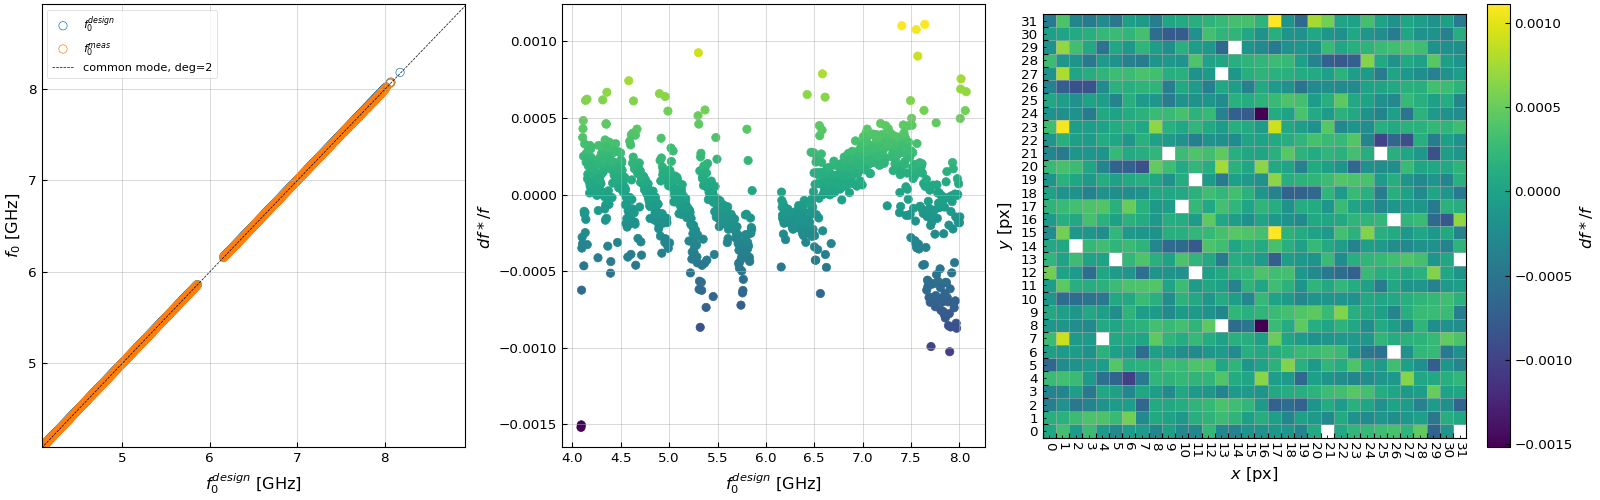

In [11]:
df_f, df_f_map = plot_scatter(2, annotate=False)

In [14]:
# master['trimdesign'] = master['trimdesign masker']
# del master['trimdesign masker']
# with open('LT402chip6_master.pkl', 'wb') as f:
#     pickle.dump(master, f)

[970. 874. 778. 682. 586. 490. 394. 298. 202. 106.  10.]
[10, 87, 173, 267, 376, 506, 620, 886]
[769.6914668  681.17706761 585.34691286 489.83434558 393.54743631
 297.91935967 201.2214024  105.96602339]


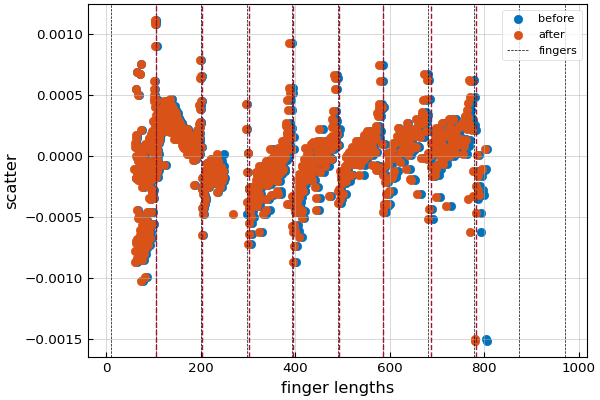

In [13]:
fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)  
ax.scatter(master['design']['fingers'], df_f)
ax.scatter(master['trimdesign']['fingers'], df_f)
ax.set_ylabel('scatter')
ax.set_xlabel('finger lengths')
fingers = np.linspace(10*1, 10*97, 11, endpoint=True)[::-1]
fingers_idx = []
trim_fingers = master['trimdesign masker']['fingers']
for finger in fingers:
    smaller = np.argwhere(trim_fingers <= finger)
    if len(smaller) and len(smaller)!=np.sum(~np.isnan(trim_fingers)):	
        fingers_idx.append(int(smaller[0][0]))
    else:
        pass
    ax.axvline(finger, ls='--', lw=0.5, c='k')
print(fingers)
print(fingers_idx)
print(trim_fingers[fingers_idx])
for id in fingers_idx:
    ax.axvline(trim_fingers[id-1], ls='--', lw=1, c='r')
ax.legend(['before', 'after', 'fingers'])

yields: 77.27 % and 95.44 % 


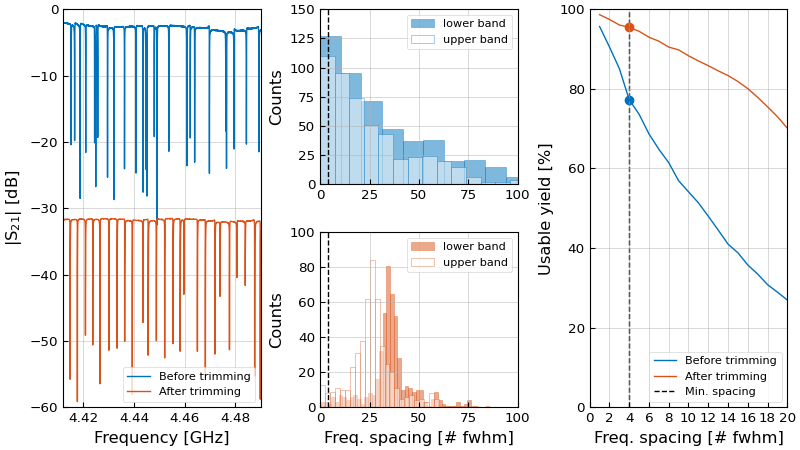

In [27]:
def comp_yield(f0s, Q, threshold):
    diffs = np.diff(f0s)
    fwhms = f0s/ Q
    rel_diffs = diffs/fwhms[:-1]
    lo_id = np.argmax(diffs)
    too_close = rel_diffs<threshold
    good = np.ones(f0s.shape)
    good[1:] -= too_close
    good[:-1] -= too_close
    spaced = np.sum(good==True)
    total = len(f0s)
    return rel_diffs, lo_id, spaced/total


def plot_spacings(f0s, Q, threshold, ax=None, title='', c='b', bins='auto'):
    rel_diffs, lo_id, yld = comp_yield(f0s, Q, threshold)
    if not ax:
        fig, ax = plt.subplots()
    else:
        _ = ax.hist(rel_diffs[:lo_id], bins=bins, alpha=.5, label='lower band', facecolor=c, edgecolor=c)
        _ = ax.hist(rel_diffs[lo_id+1:], bins=bins, alpha=.5, label='upper band', facecolor='w', edgecolor=c)
        # ax.axvline(threshold, c='r', ls='--', lw=1, label='minimal spacing')
        # ax.set_title(title + 'usable yield = %.1f%%' % (yld*1e2), fontsize=10)
        ax.set_ylabel('Counts')
        ax.legend()


path_before ='S21s_20250919_12h26\S21_dark.npy'
path_after = 'VNAsweep_30mK.dat'
fig, axes = plt.subplot_mosaic('abc;adc', figsize=(16/2,9/2), constrained_layout=True)
kids_found = np.sum(~np.isnan(meas))
# fig.suptitle('Fabrication yield = %d/%d (%.1f%%)' % (kids_found, nr, kids_found/nr*1e2), fontsize=12)
ylds_at = 4
ax = axes['a']
f, s21 = np.load(path_before)
ax.plot(f-0.1, s21-np.amax(s21), label='Before trimming')
f, s21 = load_dat_file(path_after)
ax.plot(f, s21-np.amax(s21)-30, label='After trimming')
ax.set_xlim(4.412,4.49)
ax.set_ylim(-60, 0)
ax.set_xlabel('Frequency [GHz]')
ax.set_ylabel('$|S_{21}|$ [dB]')
ax.legend()

threshold = 3
Q = 50e3

ax = axes['b']
f0s_pretrim = master['measured']['f0']
f0s_pretrim = np.sort(f0s_pretrim[~np.isnan(f0s_pretrim)])
plot_spacings(f0s_pretrim, Q, threshold, ax, title='Before, ', c='b')
ax.axvline(ylds_at, c='k', ls='--', lw=1, label='Min. spacing')
_ = ax.set_xlim([0, 100])
_ = ax.set_ylim([0, 150])

ax = axes['d']
f0s = master['trimmeasured']['f0']
f0s = np.sort(f0s[~np.isnan(f0s)])[:-12]
plot_spacings(f0s, Q, threshold, ax, title='After, ', c='o')
ax.axvline(ylds_at, c='k', ls='--', lw=1, label='Min. spacing', zorder=5)
ax.set_xlabel('Freq. spacing [# fwhm]')
_ = ax.set_xlim([0, 100])
_ = ax.set_ylim([0, 100])
ax.set_xlabel('Freq. spacing [# fwhm]')

ax = axes['c']
thresholds = np.arange(1, 21)
ylds_before = []
ylds_after = []
for threshold in thresholds:
    ylds_before.append(comp_yield(f0s_pretrim, Q, threshold)[2])
    ylds_after.append(comp_yield(f0s, Q, threshold)[2])
ax.plot(thresholds, np.array(ylds_before)*1e2, lw=1, label='Before trimming')
ax.plot(thresholds, np.array(ylds_after)*1e2, lw=1, label='After trimming')
yld_before = ylds_before[ylds_at-1]*1e2
yld_after = ylds_after[ylds_at-1]*1e2
ax.axvline(ylds_at, c='k', ls='--', lw=1, zorder=0, label='Min. spacing')
ax.scatter(ylds_at, yld_before, c='b', lw=1)
ax.scatter(ylds_at, yld_after, c='o', lw=1)
print('yields: %.2f %% and %.2f %% ' % (yld_before, yld_after))
ax.set_xlim(0, 20)
ax.set_xticks(np.arange(0, 21, 2))
ax.set_ylim(0, 100)
ax.set_xlabel('Freq. spacing [# fwhm]')
ax.set_ylabel('Usable yield [%]')
ax.legend()

plt.savefig('yield.png', dpi=300)

In [62]:
def yield_map(f0s, Q, threshold):
    nanmask = np.isnan(f0s)
    argsort = np.argsort(f0s[~nanmask])
    inverse_argsort = np.argsort(argsort)
    
    mask = np.zeros(len(f0s), dtype=float)
    mask[nanmask] = np.nan

    f0s = f0s[~nanmask][argsort]
    diffs = np.diff(f0s)
    fwhms = f0s/ Q
    rel_diffs = diffs/fwhms[:-1]
    too_close = rel_diffs<threshold
    good = np.ones(f0s.shape)
    good[1:] -= too_close
    good[:-1] -= too_close
    mask[~nanmask] = (good == True)[inverse_argsort]
    mask[mask == 0] = np.nan
    return mask

0.763671875
0.951171875


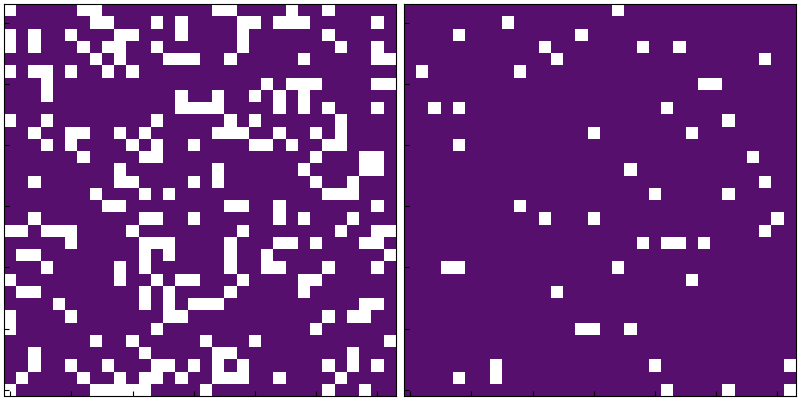

In [136]:
fig, axes = plt.subplot_mosaic('ab', figsize=(8,4), constrained_layout=True, sharex=True, sharey=True)
Q = 50e3
threshold = 4
ax = axes['a']
mask = yield_map(master['measured']['f0'], Q, threshold)
ax.imshow(mask[kid_id_board], cmap='inferno', origin='lower', vmax=4, vmin=0)
print(np.nansum(mask)/len(mask))
ax.grid()
ax = axes['b']
mask = yield_map(master['trimmeasured']['f0'], Q, threshold)
ax.imshow(mask[kid_id_board], cmap='inferno', origin='lower', vmax=4, vmin=0)
print(np.nansum(mask)/len(mask))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid()


In [55]:
maps = image(ds21s_rows)

In [ ]:
_ = plot_image(maps[:,:, 0])

In [ ]:
anim = animate_image(maps)
plt.show()

In [101]:
# with open('LT402chip6_master.pkl', 'wb') as f:
#     pickle.dump(master, f)
    